# Image Classifier using CNN
Specifically for vision, PyTorch has a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. Datasets can be loaded and preprocessed using `torchvision.datasets` and `torch.utils.data.DataLoader`.

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import os
print(os.listdir("../input"))

['cifar-10-python']


## Dataset
* Dataset used: CIFAR10
* Image size: 32x32
* 10 Classes
* 60,000 images
* 6,000 images per class
* 50,000 training images
* 10,000 test images
Sample Dataset
<img src="https://i.imgur.com/pjfNbuG.png" />

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="../input/cifar-10-python", train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="../input/cifar-10-python", train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Sample training images.

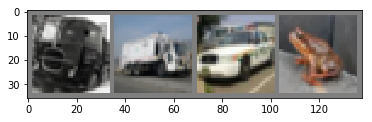

truck truck   car  frog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## CNN Model
* CNN layers: 2
* Fully connected layers: 3
* Activation function: ReLu

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loss and Optimization functions

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

## Train
Train for 2 epochs

In [6]:
train_loss = []
epoch_loss = list()
total = 0.0
correct = 0.0
for epoch in range(4):
    running_loss = 0.0
    temp_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        temp_loss += loss.item()
        running_loss += loss.item()
        if i%2000 == 1999:
            print("[%d %5d]: Loss: %.3f" % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
    epoch_loss.append(temp_loss / 2000)

train_accuracy = 100 * correct / total
print("Training complete")
print("Training Accuracy: %.3f" % (train_accuracy))

[1  2000]: Loss: 2.176
[1  4000]: Loss: 1.874
[1  6000]: Loss: 1.691
[1  8000]: Loss: 1.607
[1 10000]: Loss: 1.532
[1 12000]: Loss: 1.503
[2  2000]: Loss: 1.421
[2  4000]: Loss: 1.406
[2  6000]: Loss: 1.378
[2  8000]: Loss: 1.342
[2 10000]: Loss: 1.343
[2 12000]: Loss: 1.303
[3  2000]: Loss: 1.232
[3  4000]: Loss: 1.237
[3  6000]: Loss: 1.245
[3  8000]: Loss: 1.216
[3 10000]: Loss: 1.206
[3 12000]: Loss: 1.193
[4  2000]: Loss: 1.127
[4  4000]: Loss: 1.143
[4  6000]: Loss: 1.135
[4  8000]: Loss: 1.150
[4 10000]: Loss: 1.141
[4 12000]: Loss: 1.125
Training complete
Training Accuracy: 51.047


Sample Test data

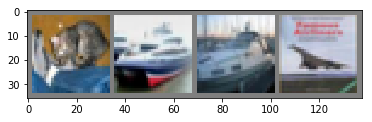

  cat  ship  ship plane


In [7]:
#testing
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Predict for test images loaded.

In [8]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted   cat   car   car plane


Predict for all the test images and compute accuracy

In [9]:
correct = 0.0
total = 0.0

with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
        
print("Accuracy of the network on %d test images: %d %%" % (total, 100 * correct / total))

Accuracy of the network on 10000 test images: 58 %


Accuracy of each class

In [10]:
#accuracy of individual classes
class_total = list(0. for i in range(10))
class_correct = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print("Accuracy of %5s class is: %d %%" % (classes[i], 100 * class_correct[i]/class_total[i]))

Accuracy of plane class is: 68 %
Accuracy of   car class is: 81 %
Accuracy of  bird class is: 41 %
Accuracy of   cat class is: 55 %
Accuracy of  deer class is: 43 %
Accuracy of   dog class is: 30 %
Accuracy of  frog class is: 70 %
Accuracy of horse class is: 59 %
Accuracy of  ship class is: 64 %
Accuracy of truck class is: 70 %
